In [1]:
# experiment meant to mirror: http://www.vision.jhu.edu/assets/TsakirisDPCPICCV15.pdf


from matplotlib import pyplot as plt

import numpy as np

import pandas as pd

import os

import cv2

import random

from sklearn.decomposition import PCA


import sys
sys.path.append('../scripts/')

import flag_dimensionality_reduction as fdr

import time

def get_data(class_name, n_pts):
    data = []
    for i in np.arange(n_pts):
        if i < 10:
            im_num = f'0{i}'
        else:
            im_num = str(i)
        image = plt.imread(f'./UCMerced_LandUse/Images/{class_name}/{class_name}{im_num}.tif')
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        small_gray_image = cv2.resize(gray_image, dsize=(100,100), interpolation=cv2.INTER_CUBIC)
        data.append(small_gray_image.flatten())

    return data

def get_outliers(class_name, n_pts, seed):
    np.random.seed(seed)
    data = []
    for i in np.random.choice(100, n_pts, replace = False):
        if i < 10:
            im_num = f'0{i}'
        else:
            im_num = str(i)
        image = plt.imread(f'./UCMerced_LandUse/Images/{class_name}/{class_name}{im_num}.tif')
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        small_gray_image = cv2.resize(gray_image, dsize=(100,100), interpolation=cv2.INTER_CUBIC)
        data.append(small_gray_image.flatten())

    return data




if __name__ == '__main__':

    
    n_in = 100
    n_outs = [20]
    fl_types = [[10]]

    times = []

    inliers = get_data('beach', n_in)

    for trial in range(5):

        for n_out  in n_outs:

            start = time.time()

            outliers = get_outliers('runway', n_out, trial)

            X_raw = np.vstack([inliers, outliers])
            pca = PCA(n_components = 50)
            X = pca.fit_transform(X_raw)

            column_means = np.mean(X, axis=0)
            Xcenter = X - column_means

            Xunit = np.vstack([x/np.linalg.norm(x) for x in X])


            labels = np.array([0]*n_in+[1]*n_out)



            for fl_type in fl_types:

                for pca_type in ['wpca', 'dpcp']:

                    if pca_type == 'dpcp':
                        if fl_type == [5,10]:
                            dfl_type = [20,40]
                        else:
                            dfl_type = [40]
                        Wfpca = fdr.flag_robust_pca(Xunit.T, dfl_type, pca_type, verbose = True, 
                                                    return_all = False, max_iters = 200, init = 'rand')

                        fpca_errs1 = []
                        for i in range(len(X)):   
                            x = Xunit[[i],:]
                            fpca_errs1.append(np.linalg.norm(x @ Wfpca))


                        

                    else:
                        Wfpca = fdr.flag_robust_pca(Xcenter.T, fl_type, pca_type, verbose = False, 
                                                    return_all = False, max_iters = 200, init = 'rand')

                        fpca_errs = []
                        for i in range(len(X)):   
                            x = Xcenter[[i],:]
                            fpca_errs.append(np.linalg.norm(x @ Wfpca @ Wfpca.T  - x))
                            
                        fpca_preds = np.array(fpca_errs)
                        fpca_preds = fpca_preds/np.max(fpca_preds)

                    
                    print(f'{pca_type} {fl_type} {n_out}')

            times.append(time.time() - start)
                    
        print()
        print()
        print('--------------------------------')


        times = np.array(times)





wpca [10] 20
--------------------
iteration 0
objective 46.00876968534322
flag distance between B0 and B1 2.8717955408849067

--------------------
iteration 1
objective 45.11934622264955
flag distance between B0 and B1 0.5665897043598066

--------------------
iteration 2
objective 45.05164648367565
flag distance between B0 and B1 0.1515444719661532

--------------------
iteration 3
objective 45.04214984361313
flag distance between B0 and B1 0.05332437690080352

--------------------
iteration 4
objective 45.04062137145701
flag distance between B0 and B1 0.02040870939235563

--------------------
iteration 5
objective 45.040359815100025
flag distance between B0 and B1 0.0082013855968032

--------------------
iteration 6
objective 45.040359815100025
flag distance between B0 and B1 0.0

dpcp [10] 20


--------------------------------
wpca [10] 20
--------------------
iteration 0
objective 45.49525901957264
flag distance between B0 and B1 2.80297148226013

--------------------
iteration 1
ob

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [3]:
fpca_preds1 = np.array(fpca_errs1)
fpca_preds1 = fpca_preds1/np.max(fpca_preds1)

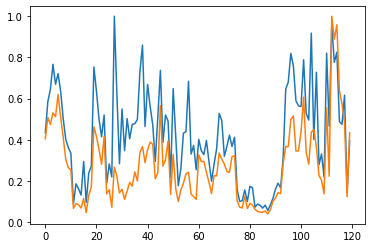

In [5]:
plt.plot(fpca_preds1)
plt.plot(fpca_preds)

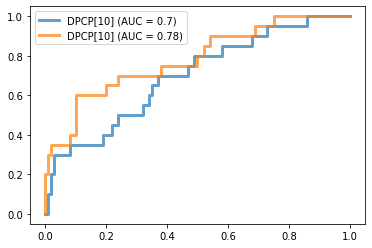

In [7]:
from sklearn.metrics import roc_curve, auc

fpr1, tpr1, thresholds = roc_curve(labels, fpca_preds1)
roc_auc1 = auc(fpr1, tpr1)
plt.plot(fpr1, tpr1, alpha = .7, lw = 3, label = f'DPCP{fl_type} (AUC = {np.round(roc_auc1,2)})')

fpr, tpr, thresholds = roc_curve(labels, fpca_preds)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, alpha = .7, lw = 3, label = f'DPCP{fl_type} (AUC = {np.round(roc_auc,2)})')

plt.legend()